## City Crime Prediction Using Clustering and Classification Techniques

Implement crime prediction final project for CS591-k1

In [1]:
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import statsmodels.formula.api as smf
import pandas
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import pandas as pd

import seaborn as sns
%matplotlib inline


In [2]:
import json
from pprint import pprint

with open('boston-rows.json') as data_file:    
    bostonjson = json.load(data_file)

print len(bostonjson['data'])

columnlist = []
for col in bostonjson['meta']['view']['columns']:
    columnlist.append(col['name'])

    

268056


    Row format= 0:sequence number, 8:id, 10: type, 12:district, 13:area, 14:date, 15:weapon type, 19:year, 20:month, 21:day of week, 26:lat,long

In [3]:
print bostonjson['data'][0][0], bostonjson['data'][0][8], bostonjson['data'][0][10], bostonjson['data'][0][12], 
print bostonjson['data'][0][13], bostonjson['data'][0][14], bostonjson['data'][0][15], bostonjson['data'][0][19], 
print bostonjson['data'][0][20], bostonjson['data'][0][21], bostonjson['data'][0][27],

1 120420285 RESIDENTIAL BURGLARY D4 629 2012-07-08T06:00:00 Other 2012 7 Sunday [None, u'42.34638135', u'-71.10379454', None, False]


In [4]:
bostondf = pd.DataFrame(bostonjson['data'])
bostondf.columns = columnlist
print columnlist
print bostondf.head()[['INCIDENT_TYPE_DESCRIPTION','FROMDATE','Location']]

[u'sid', u'id', u'position', u'created_at', u'created_meta', u'updated_at', u'updated_meta', u'meta', u'COMPNOS', u'NatureCode', u'INCIDENT_TYPE_DESCRIPTION', u'MAIN_CRIMECODE', u'REPTDISTRICT', u'REPORTINGAREA', u'FROMDATE', u'WEAPONTYPE', u'Shooting', u'DOMESTIC', u'SHIFT', u'Year', u'Month', u'DAY_WEEK', u'UCRPART', u'X', u'Y', u'STREETNAME', u'XSTREETNAME', u'Location']
  INCIDENT_TYPE_DESCRIPTION             FROMDATE  \
0      RESIDENTIAL BURGLARY  2012-07-08T06:00:00   
1        AGGRAVATED ASSAULT  2012-07-08T06:03:00   
2                   ROBBERY  2012-07-08T06:26:00   
3       COMMERCIAL BURGLARY  2012-07-08T06:56:00   
4                   ROBBERY  2012-07-08T07:15:00   

                                         Location  
0  [None, 42.34638135, -71.10379454, None, False]  
1  [None, 42.31684135, -71.07458456, None, False]  
2  [None, 42.34284135, -71.09698955, None, False]  
3   [None, 42.3164411, -71.06582908, None, False]  
4  [None, 42.27051636, -71.11989955, None, False] 

In [5]:
print bostondf['Location'][0][1]
latlist = map(lambda k: k[1], bostondf['Location'])
longlist = map(lambda k: k[2], bostondf['Location'])

typelist = map(lambda k: k, bostondf['INCIDENT_TYPE_DESCRIPTION'])
hourlist = map(lambda k: k.split("T")[1].split(":")[0], bostondf['FROMDATE'])
daylist = map(lambda k: k, bostondf['DAY_WEEK'])

print len(latlist), len(longlist), len(hourlist)

42.34638135
268056 268056 268056


### Dump parsed data to file for prediction model

In [24]:
from collections import Counter
import random

typeCnt = Counter(typelist)
print len(typeCnt)

bostonParseTimefd1 = open("data/Boston-parse-time.dat.input", "w")
bostonParseTimefd2 = open("data/Boston-parse-time.dat.trainerr", "w")

bostonParseTypefd1 = open("data/Boston-parse-type.dat.input", "w")
bostonParseTypefd2 = open("data/Boston-parse-type.dat.trainerr", "w")

bostonTestPair = open("data/Boston-parse-time.dat.testpair", "w")
SEED = 1
for i in xrange(len(bostonjson['data'])):
    SEED *= 10
    random.seed(SEED*10%1023)
    if bostonjson['data'][i][12] != None and bostonjson['data'][i][12]!='NULL' :
        if random.randint(0,99)%10:
            if random.randint(0,99)%10 in range(0,7):
                bostonParseTimefd1.write(bostonjson['data'][i][12]+"::"+daylist[i]+"::"+str(int(hourlist[i][1])/4)+"\n")
                bostonParseTypefd1.write(bostonjson['data'][i][12]+"::"+daylist[i]+"::"+str(typeCnt.keys().index(typelist[i]))+"\n")
            else:
                bostonParseTimefd2.write(bostonjson['data'][i][12]+"::"+daylist[i]+"::"+str(int(hourlist[i][1])/4)+"\n")
                bostonParseTypefd2.write(bostonjson['data'][i][12]+"::"+daylist[i]+"::"+str(typeCnt.keys().index(typelist[i]))+"\n")
        else:
            bostonTestPair.write(bostonjson['data'][i][12]+"::"+daylist[i]+"\n")
            
            
bostonParseTimefd1.close()
bostonParseTypefd1.close()
bostonParseTimefd2.close()
bostonParseTypefd2.close()

bostonTestPair.close()

127


In [88]:
import pandas as pd

Assaultlist=[]
DrugAlcohollist=[]
Othercrimeslist=[]
PublicDisorderlist=[]
Theftlist=[]
WhiteCollarCrimelist=[]
T1list=[]
T2list=[]
T3list=[]
T4list=[]
T5list=[]
T6list=[]
Weekdaylist=[]
Weekendlist=[]






crimedata ={"Latitude":latlist,"Longitude":longlist,"Crime_type":typelist,"Hour":hourlist,"Day":daylist}

crimedf=pd.DataFrame(crimedata)

#print crimedf.Crime_type.unique()

for index, row in crimedf.iterrows():
    if row['Crime_type'] in ('AGGRAVATED ASSAULT','SIMPLE ASSAULT'):
        Assaultlist.append(1)
    else:
        Assaultlist.append(0)
    if row['Crime_type'] in ('DRUG CHARGES','VIOLATION OF LIQUOR LAWS','OPERATING UNDER INFLUENCE'):
        DrugAlcohollist.append(1)
    else:
        DrugAlcohollist.append(0)
    if row['Crime_type'] in ('DISORDERLY','PubDrink'):
        PublicDisorderlist.append(1)
    else:
        PublicDisorderlist.append(0)
    if row['Crime_type'] in ('AUTO THEFT','STOLEN PROPERTY CHARGES'):
        Theftlist.append(1)
    else:
        Theftlist.append(0)
    if row['Crime_type'] in ('FRAUD','EMBEZELLMENT'):
        WhiteCollarCrimelist.append(1)
    else:
        WhiteCollarCrimelist.append(0)
    if row['Crime_type'] not in ('FRAUD','EMBEZELLMENT','FRAUD','EMBEZELLMENT','AUTO THEFT','STOLEN PROPERTY CHARGES','DISORDERLY','PubDrink','DRUG CHARGES','VIOLATION OF LIQUOR LAWS','OPERATING UNDER INFLUENCE','AGGRAVATED ASSAULT','SIMPLE ASSAULT'):
        Othercrimeslist.append(1)
    else:
        Othercrimeslist.append(0)
    if row['Hour'] in ('01','02','03','04'):
        T1list.append(1)
    else:
        T1list.append(0)
    if row['Hour'] in ('05','06','07','08'):
        T2list.append(1)
    else:
        T2list.append(0)
    if row['Hour'] in ('09','10','11','12'):
        T3list.append(1)
    else:
        T3list.append(0)
    if row['Hour'] in ('13','14','15','16'):
        T4list.append(1)
    else:
        T4list.append(0)
    if row['Hour'] in ('17','18','19','20'):
        T5list.append(1)
    else:
        T5list.append(0)
    if row['Hour'] in ('21','22','23','00'):
        T6list.append(1)
    else:
        T6list.append(0)
    if row['Day'] in ('Monday','Tuesday','Wednesday','Thursday'):
        Weekdaylist.append(1)
    else:
        Weekdaylist.append(0)
    if row['Day'] in ('Friday','Saturday','Sunday'):
        Weekendlist.append(1)
    else:
        Weekendlist.append(0)
    
        
        
        

        
crime_typedata={"Assault":Assaultlist,"DrugAlcohol":DrugAlcohollist,"PublicDisorder":PublicDisorderlist,
               "Theft":Theftlist,"WhiteCollarCrime":WhiteCollarCrimelist,"Othercrimes":Othercrimeslist}

crime_typedf=pd.DataFrame(crime_typedata)

Timedata={"T1":T1list,"T2":T2list,"T3":T3list,"T4":T4list,"T5":T5list,"T6":T6list,
         "Weekday":Weekdaylist,"Weekend":Weekendlist}

timedf=pd.DataFrame(Timedata)

#print crimedf.Day.unique()

df=crimedf[['Latitude','Longitude']]
df1 = pd.concat([df, crime_typedf], axis=1)
Crimematrix = pd.concat([df1, timedf], axis=1)

#df=df[df.Day  == 'Monday']

print Crimematrix



                Latitude          Longitude  Assault  DrugAlcohol  \
0            42.34638135       -71.10379454        0            0   
1            42.31684135       -71.07458456        1            0   
2            42.34284135       -71.09698955        0            0   
3             42.3164411       -71.06582908        0            0   
4            42.27051636       -71.11989955        0            0   
5            42.31328183        -71.0530059        0            0   
6            42.32425136       -71.08620956        0            0   
7            42.34924634       -71.06378456        1            0   
8            42.35174635       -71.16590953        0            0   
9            42.25938275       -71.11729354        0            0   
10           42.34180635       -71.09707955        0            0   
11            42.3092417       -71.05033304        0            0   
12           42.34924634       -71.06378456        0            0   
13           42.33490135       -71

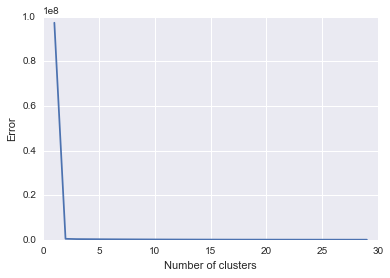

In [89]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
error = np.zeros(30)
error[0] = 0;
for k in range(1,30):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=200)
    kmeans.fit_predict(Crimematrix)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')



In [114]:
from sklearn import preprocessing as prep

Original=Crimematrix[['Latitude','Longitude']]

#Crimematrix[['Latitude','Longitude']] = Crimematrix[['Latitude','Longitude']].apply(lambda k: prep.MinMaxScaler().fit_transform(k))


#Crimematrix['Latitude']=Crimematrix['Latitude'].apply(float)
#Crimematrix['Longitude']=Crimematrix['Longitude'].apply(float)

latstd = Crimematrix['Latitude'].std()
latmean = Crimematrix['Latitude'].mean()
lolongmean = Crimematrix['Longitude'].mean()
Crimematrix['Latitude'] = Crimematrix['Latitude'].apply(lambda x: (x-latmean)/latstd)
Crimematrix['Longitude'] = Crimematrix['Longitude'].apply(lambda x: (x-longmean)/longstd)


In [115]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=200)
kmeans.fit_predict(Crimematrix)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

print "The total error of the clustering is: ", error
print '\nCluster labels'
print labels
print '\n Cluster Centroids'
print centroids

The total error of the clustering is:  319363.68741

Cluster labels
[2 2 2 ..., 1 1 1]

 Cluster Centroids
[[  2.43246419e-01   4.11018462e+00   8.46357231e-02   5.50326001e-02
    7.91719154e-01   1.05206329e-02   2.03698833e-02   3.77220061e-02
    5.75381719e-02   1.09089273e-01   2.25010036e-01   2.12973602e-01
    2.20988663e-01   1.74400255e-01   1.00000000e+00  -7.07156556e-13]
 [ -4.11008895e+00   4.17134638e+00   6.18116281e-02   4.17195114e-02
    8.48140979e-01   7.74314131e-03   1.19484681e-02   2.86362726e-02
    7.29590815e-02   9.59882518e-02   2.12268874e-01   2.18276484e-01
    2.25285361e-01   1.75221948e-01   5.81269608e-01   4.18730392e-01]
 [  2.43372160e-01   4.11018492e+00   9.38515797e-02   4.34910725e-02
    8.00869269e-01   1.20997818e-02   2.12989309e-02   2.83893662e-02
    1.20316399e-01   8.46708473e-02   1.87896535e-01   1.92767756e-01
    2.08044421e-01   2.06304042e-01   7.07434111e-13   1.00000000e+00]]


In [116]:

clusterdf = pd.DataFrame.copy(Crimematrix)
clusterdf['lat'] = Original['Latitude']
clusterdf['long'] = Original['Longitude']
clusterdf['labels'] = labels

cluster1=clusterdf[clusterdf['labels'] == 0]
cluster2=clusterdf[clusterdf['labels'] == 1]
cluster3=clusterdf[clusterdf['labels'] == 2]



In [117]:
#print Crimematrix.columns

def clustersOf(df):
    print "Assault :",df['Assault'].sum()
    print "DrugAlcohol :",df['DrugAlcohol'].sum()
    print "Othercrimes",df['Othercrimes'].sum()
    print "PublicDisorder",df['PublicDisorder'].sum()
    print "Theft",df['Theft'].sum()
    print "WhiteCollarCrime",df['WhiteCollarCrime'].sum()
    print "T1",df['T1'].sum()
    print "T2",df['T2'].sum()
    print "T3",df['T3'].sum()
    print "T4",df['T4'].sum()
    print "T5",df['T5'].sum()
    print "T6",df['T6'].sum()
    print "Weekday",df['Weekday'].sum()
    print "Weekend",df['Weekend'].sum()
    print "------------------------------"

In [118]:
clustersOf(cluster1)
clustersOf(cluster2)
clustersOf(cluster3)


Assault : 12228
DrugAlcohol : 7951
Othercrimes 114386
PublicDisorder 1520
Theft 2943
WhiteCollarCrime 5450
T1 8313
T2 15761
T3 32509
T4 30770
T5 31928
T6 25197
Weekday 144478
Weekend 0
------------------------------
Assault : 926
DrugAlcohol : 625
Othercrimes 12706
PublicDisorder 116
Theft 179
WhiteCollarCrime 429
T1 1093
T2 1438
T3 3180
T4 3270
T5 3375
T6 2625
Weekday 8708
Weekend 6273
------------------------------
Assault : 10192
DrugAlcohol : 4723
Othercrimes 86972
PublicDisorder 1314
Theft 2313
WhiteCollarCrime 3083
T1 13066
T2 9195
T3 20405
T4 20934
T5 22593
T6 22404
Weekday 0
Weekend 108597
------------------------------


In [119]:
import gmplot
gmap = gmplot.GoogleMapPlotter(42, -71, 10)



gmap.scatter(cluster1['lat'],cluster1['long'], c='#00ff00', marker=False) #Green
gmap.scatter(cluster2['lat'],cluster2['long'], c='#000000', marker=False) #Black
gmap.scatter(cluster3['lat'],cluster3['long'], c='#ffff00', marker=False) #Yellow
gmap.draw("clustering.html")

#print Crimematrix